# Exploratory analysis of Dota 2 tournament data

Dota 2 is a multiplayer online battle arena (MOBA) video game developed and published by Valve Corporation. It is played in matches between two teams of five players, the _Radiant_ and the _Dire_, with each team occupying and defending their own separate base on the map. Each of the ten players independently controls a powerful character, known as a "hero", who all have unique abilities and differing styles of play. A team wins by being the first to destroy the other team's "Ancient", a large structure located within their base.<sup>[1]</sup>

In this notebook, you will do some exploratory analysis of Dota's biggest tournament, [The International](https://en.wikipedia.org/wiki/The_International_(Dota_2)). The dataset provided has all the matches from the 2018 edition of the tournament.

[1]: https://en.wikipedia.org/wiki/Dota_2

## Draft stage

Players select their hero during a pre-game drafting phase, where they can also discuss potential strategies and hero matchups with their teammates. Heroes are removed from the drafting pool and become unavailable for all other players once one is selected, and can not be changed once the drafting phase is over. During this stage, teams also **ban** heroes from the pool, so no team can select them.

## Loading the dataset

In [1]:
import pandas as pd

df = pd.read_json("data/data.json")
df.head()

# NOTE: using pandas=0.24.2

,match_id,date,duration,radiant_team,radiant_picks,radiant_bans,radiant_score,dire_team,dire_picks,dire_bans,dire_score,radiant_win
0,4061660411,2018-08-15 16:02:15,3031,Fnatic,"[Io, Gyrocopter, Bane, Tiny, Enigma]","[Chen, Nature's Prophet, Weaver, Enchantress, ...",41,Team Liquid,"[Earthshaker, Crystal Maiden, Broodmother, Pug...","[Silencer, Necrophos, Meepo, Brewmaster, Kunkk...",42,False
1,4061662358,2018-08-15 16:03:47,3035,Evil Geniuses,"[Phoenix, Ursa, Crystal Maiden, Clinkz, Alchem...","[Pugna, Tiny, Silencer, Dark Willow, Elder Tit...",49,VGJ Thunder,"[Weaver, Vengeful Spirit, Wraith King, Winter ...","[Io, Necrophos, Enchantress, Rubick, Kunkka, S...",38,True
10,4061815647,2018-08-15 18:44:13,2457,Team Secret,"[Necrophos, Pugna, Rubick, Ogre Magi, Dragon K...","[Silencer, Pudge, Enchantress, Mirana, Lycan, ...",14,Team Serenity,"[Nyx Assassin, Clinkz, Crystal Maiden, Lina, T...","[Visage, Drow Ranger, Enigma, Arc Warden, Undy...",42,False
100,4065042825,2018-08-17 20:59:58,2314,Winstrike,"[Nature's Prophet, Vengeful Spirit, Night Stal...","[Io, Broodmother, Enchantress, Necrophos, Weav...",19,Team Liquid,"[Wraith King, Keeper of the Light, Chen, Drago...","[Clockwerk, Undying, Pugna, Drow Ranger, Phant...",25,False
101,4065077879,2018-08-17 21:41:14,2258,VGJ Thunder,"[Silencer, Clinkz, Tiny, Dark Willow, Lycan]","[Io, Enchantress, Nature's Prophet, Pugna, Nec...",28,Mineski,"[Wraith King, Mirana, Vengeful Spirit, Huskar,...","[Weaver, Terrorblade, Luna, Phantom Lancer, Un...",10,True


The data contains serveral columns:

- **Duration**: Match duration in seconds
- **Radiant_team** / **Dire_team**: Name of the team that plays as the Radiant/Dire side
- **Radiant_score** / **Dire_score**: The number of player kills for the Radiant/Dire side
- **Radiant_picks** / **Dire_picks**: A list of the _drafted_ heroes by the Radiant/Dire side
- **Radiant_bans** / **Dire_bans**: A list of the _banned_ heroes by the Radiant/Dire side
- **Radiant_win**: `True` if match resulted in a Radiant victory, `False` when Dire won

## First questions

To answer these questions some standard operations with [`pandas`](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html) should suffice.

#### 1. How many matches are in the dataset?

In [2]:
total_matches = df.shape[0]

# I'm assuming `match_id` values are unique. A quick check could be:

# unique_ids = df['match_id'].unique().shape[0]
# assert total_matches == unique_ids

#### 2. How many wins by the Radiant side? How many wins by the Dire side?

In [3]:
radiant_wins = df['radiant_win'].sum()
dire_wins = (~df['radiant_win']).sum()

# assert dire_wins == total_matches - radiant_wins

#### 3. Find the longest and the shortest match in the tournament

In [4]:
longest_match = df.loc[df['duration'].idxmax()]
shortest_match = df.loc[df['duration'].idxmin()]

# assert (df['duration'] <= longest_match['duration']).all()
# assert (df['duration'] >= shortest_match['duration']).all()

#### 4. Which team won the most matches? Which won the least?

In [5]:
most_wins = 'radiant' if radiant_wins > dire_wins else 'dire'
least_wins = 'radiant' if radiant_wins < dire_wins else 'dire'

#### 5. What was the last match played in the tournament? (Just return the match_id)

In [6]:
last_match = df.sort_values(by='date').iloc[-1,0]

# assert (df['date'] <= df[ df['match_id'] == last_match]['date'].values[0]).all()

#### 6. Match scores

Find the following matches (if there are ties, just return a list of match_ids):

- Match with the most amount of kills in _total_
- Match with the least amount of kills in _total_
- Most lopsided match (the match with the highest difference between the score of the winner and the score of the loser)
- Tightest match (where the score difference is the smallest)

In [7]:
df

,match_id,date,duration,radiant_team,radiant_picks,radiant_bans,radiant_score,dire_team,dire_picks,dire_bans,dire_score,radiant_win
0,4061660411,2018-08-15 16:02:15,3031,Fnatic,"[Io, Gyrocopter, Bane, Tiny, Enigma]","[Chen, Nature's Prophet, Weaver, Enchantress, ...",41,Team Liquid,"[Earthshaker, Crystal Maiden, Broodmother, Pug...","[Silencer, Necrophos, Meepo, Brewmaster, Kunkk...",42,False
1,4061662358,2018-08-15 16:03:47,3035,Evil Geniuses,"[Phoenix, Ursa, Crystal Maiden, Clinkz, Alchem...","[Pugna, Tiny, Silencer, Dark Willow, Elder Tit...",49,VGJ Thunder,"[Weaver, Vengeful Spirit, Wraith King, Winter ...","[Io, Necrophos, Enchantress, Rubick, Kunkka, S...",38,True
10,4061815647,2018-08-15 18:44:13,2457,Team Secret,"[Necrophos, Pugna, Rubick, Ogre Magi, Dragon K...","[Silencer, Pudge, Enchantress, Mirana, Lycan, ...",14,Team Serenity,"[Nyx Assassin, Clinkz, Crystal Maiden, Lina, T...","[Visage, Drow Ranger, Enigma, Arc Warden, Undy...",42,False
100,4065042825,2018-08-17 20:59:58,2314,Winstrike,"[Nature's Prophet, Vengeful Spirit, Night Stal...","[Io, Broodmother, Enchantress, Necrophos, Weav...",19,Team Liquid,"[Wraith King, Keeper of the Light, Chen, Drago...","[Clockwerk, Undying, Pugna, Drow Ranger, Phant...",25,False
101,4065077879,2018-08-17 21:41:14,2258,VGJ Thunder,"[Silencer, Clinkz, Tiny, Dark Willow, Lycan]","[Io, Enchantress, Nature's Prophet, Pugna, Nec...",28,Mineski,"[Wraith King, Mirana, Vengeful Spirit, Huskar,...","[Weaver, Terrorblade, Luna, Phantom Lancer, Un...",10,True
102,4065083072,2018-08-17 21:47:38,2334,Fnatic,"[Weaver, Vengeful Spirit, Crystal Maiden, Spec...","[Enchantress, Io, Drow Ranger, Dragon Knight, ...",23,PSG.LGD,"[Tiny, Silencer, Earthshaker, Terrorblade, Pugna]","[Winter Wyvern, Keeper of the Light, Meepo, Un...",28,False
103,4065084843,2018-08-17 21:49:58,2261,OG,"[Silencer, Dragon Knight, Lina, Phantom Lancer...","[Mirana, Wraith King, Medusa, Alchemist, Gyroc...",36,INVICTUS GAMING,"[Weaver, Vengeful Spirit, Undying, Bloodseeker...","[Enchantress, Chen, Nature's Prophet, Arc Ward...",41,True
104,4065095713,2018-08-17 22:03:36,2109,paiN Gaming,"[Dark Willow, Ursa, Undying, Nature's Prophet,...","[Broodmother, Silencer, Enchantress, Pugna, Ph...",18,Virtus.pro,"[Tiny, Chen, Windranger, Storm Spirit, Wraith ...","[Enigma, Necrophos, Weaver, Mirana, Clinkz, Me...",40,False
105,4065124105,2018-08-17 22:43:06,1908,VGJ Storm,"[Wraith King, Necrophos, Undying, Keeper of th...","[Io, Enchantress, Weaver, Phantom Lancer, Enig...",22,Newbee,"[Silencer, Dark Willow, Clinkz, Nyx Assassin, ...","[Mirana, Chen, Nature's Prophet, Pugna, Drow R...",13,True
106,4065128649,2018-08-17 22:49:32,2338,Team Secret,"[Mirana, Crystal Maiden, Elder Titan, Arc Ward...","[Enchantress, Io, Wraith King, Bloodseeker, Hu...",44,Optic Gaming,"[Necrophos, Ogre Magi, Windranger, Storm Spiri...","[Tiny, Weaver, Clinkz, Pugna, Nyx Assassin, Em...",16,True


In [8]:
most_kills_match = df[ (df['radiant_score'] + df['dire_score']).abs() == (df['radiant_score'] 
                        + df['dire_score']).max() ]['match_id']

least_kills_match = df[ (df['radiant_score'] + df['dire_score']).abs() == (df['radiant_score'] 
                        + df['dire_score']).min() ]['match_id']

lopsided_match = df[ (df['radiant_score'] - df['dire_score']).abs() == (df['radiant_score'] 
                        - df['dire_score']).abs().max() ]['match_id']

tightest_match = df.loc[ (df['radiant_score'] - df['dire_score']) == 1 ]['match_id']

## Plots

To answer the following questions you can use any of the available plotting libraries (`matplotlib`, `seaborn`, `bokeh`, `plotly`).

#### 7. Plot the number of wins per team

<BarContainer object of 2 artists>

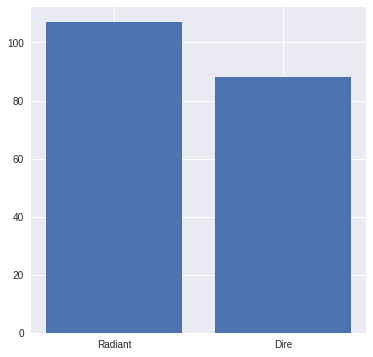

In [9]:
# Change imports if using a different library
%matplotlib inline
import matplotlib.pyplot as plt

# Your answer here
plt.style.use('seaborn')
plt.figure(figsize=(6,6))
plt.bar(['Radiant', 'Dire'], height=[radiant_wins, dire_wins])

#### 8. Plot a histogram of the total number of kills per match

(array([ 3.,  2.,  8., 17., 15., 19., 21., 24., 17., 18., 15., 11., 10.,
         3.,  5.,  3.,  2.,  0.,  0.,  2.]),
 array([ 24. ,  28.2,  32.4,  36.6,  40.8,  45. ,  49.2,  53.4,  57.6,
         61.8,  66. ,  70.2,  74.4,  78.6,  82.8,  87. ,  91.2,  95.4,
         99.6, 103.8, 108. ]),
 <a list of 20 Patch objects>)

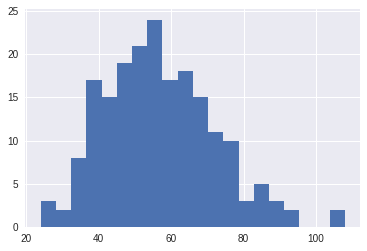

In [10]:
# Your answer here
plt.hist((df['radiant_score'] + df['dire_score']), bins=20)

## Advanced questions

These questions require more code. Feel free to add code cells with your own functions and even some brief explanations on how you intend to solve them.

#### 9. What are the top 3 heroes played on the Radiant side? Top 3 on the Dire?

In [11]:
# The main idea is taking advantage of `+` operator applied to lists.
# In the end we will have a long list with repeated names.

radiant_heroes_all = []
for row in df['radiant_picks']:
    radiant_heroes_all += row

In [12]:
# pd.Series objects have the `value_counts` method that we need. 

radiant_heroes_count = pd.Series(radiant_heroes_all).value_counts()
radiant_heroes_top = radiant_heroes_count.index[:3].tolist()
radiant_heroes_top

['Vengeful Spirit', 'Necrophos', 'Weaver']

In [13]:
dire_heroes_all = []
for row in df['dire_picks']:
    dire_heroes_all += row

In [14]:
dire_heroes_count = pd.Series(dire_heroes_all).value_counts()
dire_heroes_top = dire_heroes_count.index[:3].tolist()
dire_heroes_top

['Tiny', 'Mirana', 'Vengeful Spirit']

In [15]:
top_3_radiant = ['Vengeful Spirit', 'Necrophos', 'Weaver']
top_3_dire = ['Tiny', 'Mirana', 'Vengeful Spirit']

#### 10. What is the winrate (number of matches won / total matches) for the Radiant/Dire when they draft _Weaver_

Notice that the denominator is **not** the total number of matches in the dataset, but the number of matches where Weaver was picked for the Radiant/Dire.

In [16]:
is_weaver_radiant = []
is_weaver_dire = []

for i, row in df.iterrows():
    if 'Weaver' in row['radiant_picks']:
        is_weaver_radiant.append(True)
        
    else:
        is_weaver_radiant.append(False)
    
    if 'Weaver' in row['dire_picks']:
        is_weaver_dire.append(True)
        
    else:
        is_weaver_dire.append(False)

In [17]:
radiant_matches_wv = df[is_weaver_radiant]
dire_matches_wv = df[is_weaver_dire]

In [18]:
radiant_wv_tot = len(radiant_matches_wv)
radiant_wv_win = radiant_matches_wv['radiant_win'].sum()

radiant_wv_win/radiant_wv_tot

0.6388888888888888

In [19]:
dire_wv_tot = len(dire_matches_wv)
dire_wv_win = (~dire_matches_wv['radiant_win']).sum()

dire_wv_win/dire_wv_tot

0.5

In [20]:
radiant_weaver_winrate = 0.6389
dire_weaver_winrate = 0.5